https://towardsdatascience.com/nlp-classification-with-universal-language-model-fine-tuning-ulmfit-4e1d5077372b

https://towardsdatascience.com/fastai-disaster-prediction-using-ulmfit-4dd244d3889c


https://docs.fast.ai/tutorial.text.html

In [ ]:
# !pip install fastai
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import itertools
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from fastai.text import *
from fastai.callbacks import *

In [ ]:
import fastai
print(fastai.__version__)

1.0.61


In [ ]:
train_df = pd.read_csv("P1-Golden.csv")
test_df = pd.read_csv("P1_test.csv")

In [ ]:
# df.to_csv("P1-Golden.csv")

In [ ]:
!pip3 install nvidia-ml-py3


In [ ]:
from pynvml import *
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(handle)
print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

Total memory: 11996954624
Free memory: 9710665728
Used memory: 2286288896


In [ ]:
nvmlInit()
try:
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
except NVMLError as error:
    print(error)

Device 0 : b'Tesla K80'


In [ ]:
train_df.reviews.values

array(["Well done Microsoft!! OneNote is a fantastic program, perfect for day to day stuff and college notes. In fact, everything where a word processor isn't quite the write [sic] tool. I've been waiting for an iPhone app to use OneNote remotely, and this exceeds my expectations!!If you are a OneNote user, I really can't see how you could be disappointed with this perfect companion. Great looking and does the job perfectly!(I had a problem signing in at first, but resubmitted a few times and it worked - now I have no trouble logging in)",
       'This works on a limited basis.  Works well for retrieval of notes and is ok with entry of notes.  Ability to handwrite notes would be great and handwriting recognition would be incredible.  I would pay for an iPad app with more functionality but this works fine for free.',
       "This app was great for the first month or two. Now whenever I try to open one of my notes, it says, Syncing Error. Edits saved to SkyDrive. I've been trying to acce

In [ ]:
path = "."
data_lm = (TextList
           .from_df(pd.concat([train_df[["reviews"]],test_df[["reviews"]]],ignore_index=True,axis=0))
           #Where are the text? Column 'text' of tweets.csv
           .split_by_rand_pct(0.2)
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()
           #Label it for a language model
           .databunch(bs=48)
          )
           #Finally we convert to a DataBunch
data_lm.show_batch()    

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


idx,text
0,"n't see how you could be disappointed with this perfect xxunk . xxmaj great looking and does the job xxunk had a problem signing in at first , but xxunk a few times and it worked - now i have no trouble xxunk in ) xxbos i ca n't update it in my phone it takes way too much xxunk . xxbos xxmaj love it . xxmaj between my xxup"
1,xxunk take notes on my phone and they will appear on my ipad ! ! xxbos xxmaj xxunk xxbos xxmaj love the layout as well . xxmaj very user - friendly and looks clean ! xxbos xxmaj keep it coming . i would like the feature of xxunk xxunk xxunk xxunk within the tabs on the iphone . xxbos i especially like it is xxunk xxunk platform . i prefer
2,great with note s xxunk xxbos xxmaj use lots of xxunk data in background xxmaj it took about xxunk xxup xxunk cell phone data in 2 days before i found out . xxbos xxmaj xxunk language is not supported xxmaj the characters appear xxunk and in the right ( xxup xxunk ) xxunk xxmaj please xxmaj fix that ! xxbos xxunk nice xxbos i have n't used it much and
3,"terrible . xxmaj this has been the best app until lately . xxbos xxmaj screen xxunk ? ? xxmaj too xxmaj much screen at top now being used ! ! xxmaj xxunk a lot xxbos xxmaj best app for twitter - xxmaj after trying several other twitter apps , xxmaj tweetcaster is xxunk the best for the xxunk system . xxbos xxmaj easy to use , xxunk recommend xxbos xxmaj"
4,"it also needs push notifications . xxmaj definitely xxunk back to the regular twitter app . xxbos xxmaj like it alot xxbos xxmaj after using xxmaj tweetcaster for a couple years i had an issue for several months where it xxunk xxunk to let me even log in to my xxmaj facebook , xxunk trying to post to it . i xxunk to xxmaj hootsuite and lost a couple features"


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-01
Min loss divided by 10: 7.59E-02


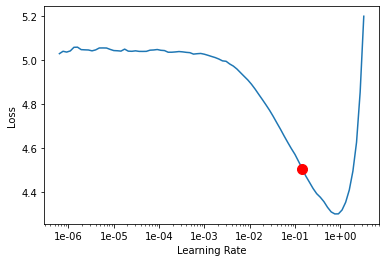

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
#find the optimal learning rate & visualize it
learn.lr_find();
learn.recorder.plot(suggestion= True);

In [ ]:
learn.fit_one_cycle(6,5e-2, moms=(0.85,0.75)) #5e-2


epoch,train_loss,valid_loss,accuracy,time
0,4.772425,4.009198,0.220089,00:02
1,4.219273,3.607133,0.252530,00:02
2,3.822599,3.554509,0.249702,00:02
3,3.517434,3.551341,0.265774,00:02
4,3.273556,3.555188,0.259375,00:02
5,3.088929,3.552860,0.258185,00:02


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.447859,3.648186,0.257887,00:02
1,2.324263,3.978938,0.235565,00:02
2,2.295341,4.045519,0.225149,00:02
3,2.092528,4.208786,0.232589,00:02
4,1.787229,4.432257,0.233036,00:02
5,1.508701,4.472188,0.234970,00:02
6,1.283718,4.427613,0.231696,00:02
7,1.110985,4.398905,0.230208,00:02
8,0.972324,4.373793,0.235565,00:02
9,0.864309,4.362955,0.237054,00:02


In [ ]:

TEXT = "I love this application because"
N_WORDS = 40
N_SENTENCES = 2
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))
#Save fine-tuned model for future use
learn.save('fine-tuned')
learn.save_encoder('fine_tuned_enc')

I love this application because it 's much better than the original twitter app xxbos Great app . Love that i can scan several different functions and it crashes every time i try to send a tweet . xxbos i like it .
I love this application because it 's good to talk to other friends i try it in one place together . It 's great ! xxbos Love it !!!! xxbosxxbosxxbosxxbos When you Follow several down Twitter accounts ,


In [ ]:
data_clas = (TextList.from_csv(".", 'P1-Golden.csv', cols='reviews',vocab=data_lm.vocab)
             #Where are the text? Column 'text' of tweets.csv
             .split_by_rand_pct(0.2)
             #How to split it? Randomly with the default 20% in valid
             .label_from_df(cols='Judgement')
            #  .add_test(TextList.from_csv(".", 'P1_test.csv', cols='reviews',vocab=data_lm.vocab))
             #specify the label column
             .databunch(bs=64))
             #Create databunch
data_clas.show_batch()

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
"xxbos i 've been xxunk for this app for a long time . i love the pc version of xxmaj onenote , but xxunk something more xxunk to a mobile device . xxmaj unfortunately , i have n't been xxunk back from xxmaj evernote . i have n't had the problems everyone is talking about , but xxunk , some xxunk features are missing . xxmaj while i really like",1
"xxbos xxmaj this app was great for the first xxunk or two . xxmaj now xxunk i try to open one of my notes , it says , xxmaj xxunk xxmaj error . xxmaj xxunk saved to xxunk . i 've been trying to access this note for xxup xxunk xxup days now . i have tried xxunk xxunk , signing out , xxunk , going to xxmaj xxunk ,",1
"xxbos i run xxup xxunk on my iphone using the one note app , and it is xxunk to the way i run my business . xxmaj in my xxunk , there is absolutely no xxunk . xxmaj it xxunk links to all of the notes i have on my laptop , it xxunk xxunk any xxunk notes i have , and it allows me to update or add any",1
"xxbos xxmaj keeps getting better , new xxunk update works very well . xxmaj in over 30 years of using and writing software i have never xxunk as well thought out design and xxunk . xxmaj like all products there are small bugs and xxunk , especially on small xxunk , but the amazing technology far xxunk the xxunk . xxmaj not many realize the xxunk xxunk in the onenote",1
"xxbos xxmaj ok i load it and they make me xxmaj follow them . xxmaj then it is xxunk to xxunk out how to xxunk them . xxmaj then i try to send a link of an xxunk . xxmaj my link is in there but the xxunk line is : xxmaj check out this link from xxunk inside the email only my link , no xxunk and more xxunk",1


In [ ]:
# config = awd_lstm_lm_config.copy()
# config['n_hid'] = 1150

# data_clas.vocab.itos = data_lm.vocab.itos
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,metrics=[accuracy, FBeta(beta=1)])
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (719 items)
x: TextList
xxbos xxmaj well done xxmaj microsoft ! ! onenote is a fantastic program , perfect for day to day stuff and xxunk notes . xxmaj in fact , everything where a word xxunk is n't quite the xxunk xxunk xxunk xxunk tool . i 've been xxunk for an iphone app to use onenote xxunk , and this xxunk my xxunk you are a onenote user , i really ca n't see how you could be disappointed with this perfect xxunk . xxmaj great looking and does the job xxunk had a problem signing in at first , but xxunk a few times and it worked - now i have no trouble xxunk in ),xxbos xxmaj this works on a limited xxunk . xxmaj works well for xxunk of notes and is ok with xxunk of notes . xxmaj ability to xxunk notes would be great and xxunk xxunk would be xxunk . i would pay for an ipad app with more functionality but this works fine for free .,xxbos xxmaj this app was great for the first xxunk or two . xxmaj now xxunk i try to open one of my no

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 3.98E-03


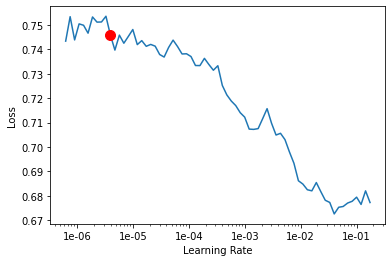

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15, suggestion=True)

In [ ]:
learn.fit_one_cycle(4, 5e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.698992,0.487625,0.726257,0.760976,00:01
1,0.712602,0.519419,0.698324,0.550000,00:01
2,0.704847,0.543602,0.715084,0.592000,00:01
3,0.668125,0.494001,0.743017,0.656716,00:01


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.535417,0.448106,0.798883,0.756757,00:01
1,0.540598,0.423063,0.782123,0.745098,00:01
2,0.551942,0.429748,0.793296,0.748299,00:01
3,0.543889,0.422360,0.793296,0.758170,00:01


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.541765,0.428148,0.787709,0.756410,00:02
1,0.516718,0.410390,0.798883,0.766234,00:02
2,0.462261,0.419435,0.793296,0.744828,00:02
3,0.436947,0.400264,0.821229,0.789474,00:02


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
# callbacks = SaveModelCallback(learn,monitor="accuracy", mode="max", name="best_classification_model")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


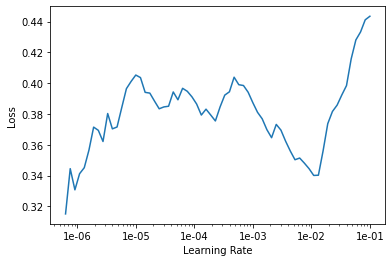

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn.save('fwd_clas')

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.294855,0.397983,0.826816,0.800000,00:03
1,0.349865,0.419005,0.804469,0.761905,00:03
2,0.354894,0.419872,0.821229,0.792208,00:03
3,0.356669,0.418571,0.810056,0.784810,00:03
4,0.342497,0.418640,0.815642,0.792453,00:03


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [ ]:
pred_fwd,lbl_fwd = learn.get_preds(ordered=True)
accuracy(pred_fwd, lbl_fwd)

tensor(0.8156)

In [ ]:
print('Loading existing model')
learn = load_learner('.')
preds = []
for i in range(0,test_df.shape[0]):
    p = learn.predict(test_df.reviews[i])
    preds.append(int(p[0]))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print(classification_report(test_df.Judgement.values, preds))
print(confusion_matrix(test_df.Judgement.values, preds))

Loading existing model


              precision    recall  f1-score   support

           0       0.83      0.84      0.83        51
           1       0.84      0.82      0.83        51

    accuracy                           0.83       102
   macro avg       0.83      0.83      0.83       102
weighted avg       0.83      0.83      0.83       102

[[43  8]
 [ 9 42]]


In [ ]:
learn.export()

In [ ]:
learn = load_learner('.')


In [ ]:
learn.predict("Love it. Between my PC and my phone I'm in sync, That's good for me. If you use notes..... This is the app. It's part of office now and is integrated perfectly. I live by OneNote. One place for all thoughts, ideas, personal or professional")

(Category tensor(0), tensor(0), tensor([1.0000e+00, 2.0438e-07]))

In [ ]:
learn.predict("Love it. Between my PC and my phone I'm in sync, That's good for me. If you use notes..... This is the app. It's part of office now and is integrated perfectly. I live by OneNote. One place for all thoughts, ideas, personal or professional")

(Category tensor(0), tensor(0), tensor([1.0000e+00, 2.0438e-07]))

In [ ]:
learn.predict("Well done Microsoft!! OneNote is a fantastic program, perfect for day to day stuff and college notes. In fact, everything where a word processor isn't quite the write [sic] tool. I've been waiting for an iPhone app to use OneNote remotely, and this exceeds my expectations!!If you are a OneNote user, I really can't see how you could be disappointed with this perfect companion. Great looking and does the job perfectly!(I had a problem signing in at first, but resubmitted a few times and it worked - now I have no trouble logging in)")

(Category tensor(1), tensor(1), tensor([0.0339, 0.9661]))

In [ ]:


# !pip install fastai
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import itertools
import nltk
from nltk.corpus import stopwords
# from wordcloud import WordCloud,STOPWORDS
from fastai.text import *
# from fastai.learner import load_learner
import fastai
# from fastai.callbacks import *

def train_ulm(dat_lm):
    learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
    #find the optimal learning rate & visualize it
    learn.lr_find()
    learn.recorder.plot(suggestion= True)

    learn.fit_one_cycle(6,5e-2, moms=(0.85,0.75)) #5e-2

    learn.unfreeze()
    learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7))

    TEXT = "I love this application because"
    N_WORDS = 40
    N_SENTENCES = 2
    print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))
    #Save fine-tuned model for future use
    learn.save('fine-tuned')
    learn.save_encoder('fine_tuned_enc')

    data_clas = (TextList.from_csv(".", 'P2-Golden.csv', cols='reviews',vocab=data_lm.vocab)
                #Where are the text? Column 'text' of tweets.csv
                .split_by_rand_pct(0.2)
                #How to split it? Randomly with the default 20% in valid
                .label_from_df(cols='Judgement')
                #  .add_test(TextList.from_csv(".", 'P1_test.csv', cols='reviews',vocab=data_lm.vocab))
                #specify the label column
                .databunch(bs=64))
                #Create databunch
    data_clas.show_batch()

    # Applying UlmFit Language model as a Text Classifier
    learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,metrics=[accuracy, FBeta(beta=1)])
    learn.load_encoder('fine_tuned_enc')

    learn.lr_find()
    learn.recorder.plot(skip_end=15, suggestion=True)

    learn.fit_one_cycle(4, 5e-2, moms=(0.8,0.7))

    learn.freeze_to(-2)
    learn.fit_one_cycle(4, slice(1e-3/(2.6**4), 1e-3), moms=(0.8,0.7))

    learn.freeze_to(-3)
    learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

    learn.unfreeze()
    learn.lr_find()
    learn.recorder.plot(skip_end=15)

    learn.fit_one_cycle(5, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
    #Final text classifier model 
    learn.save('fwd_clas')
    #Exports the model by default as "export.pkl"
    learn.export()

if __name__ == '__main__':
    DEMO = True

    train_df = pd.read_csv("P2-Golden.csv")
    test_df = pd.read_csv("P2_test.csv")

    data_lm = (TextList
           .from_df(pd.concat([train_df[["reviews"]],test_df[["reviews"]]],ignore_index=True,axis=0))
           #Where are the text? Column 'text' of tweets.csv
           .split_by_rand_pct(0.2)
           #How to split it? Randomly with the default 20% in valid
           .label_for_lm()
           #Label it for a language model
           .databunch(bs=48)
          )
    #Finally we convert to a DataBunch
    data_lm.show_batch()
    
    if DEMO == False:
        print("Training model")
        learn = train_ulm(data_lm)
        pred_fwd,lbl_fwd = learn.get_preds(ordered=True)
        accuracy(pred_fwd, lbl_fwd)
    else:
        print('Loading existing model')
        learn = load_learner('.')
        print(learn)
        preds = []
        for i in range(0,test_df.shape[0]):
            p = learn.predict(test_df.reviews[i])
            preds.append(int(p[0]))
        
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import classification_report
        # int_preds = []
        # for i in preds:
        #   int_preds.append(int(i))
        print(classification_report(test_df.Judgement.values, preds))
        print(confusion_matrix(test_df.Judgement.values, preds))
        # accuracy(preds, test_df.Judgement.values)

    print("Sample data predictions:")
    print(learn.predict("Now I bought an iPhone six running iOS 8."))
    # [1.0000e+00, 2.0438e-07] - The first number is the probability of text having no requirement
    #The second number is the probability of text having requirement. 
    #Therefore, the model predicts that the text does not have any requirement.

    print(learn.predict("However, it won't let me sign on. it doesn't send me an access code."))
    # [0.0339, 0.9661] - We can see that the model has predicted correctly that the requirement is present in this text

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


idx,text
0,"until i just updated the app and i ca n't xxunk to send any messages . xxbos xxmaj when i do try to send a message through chat , the app crashes . xxbos xxup xxunk . xxbos i 've xxunk my phone on and off several times thinking it could be the xxunk of something else but the app is still crashing during every message i 'm trying to"
1,"for long xxunk , since i have it i call my family through this application and works perfectly i have trouble with video call . xxbos xxmaj need xxmaj help ! ! xxbos i make a lot of calls from xxmaj xxunk to xxup xxunk . xxbos xxmaj if you 're on wifi and the other person is on at least 3 g , call quality is clear . xxbos"
2,"allow me to let only xxunk xxunk chat / call me and xxunk xxunk xxunk from sending messages to me ? xxbos xxmaj this is getting more and more important each day . xxbos xxmaj thank you . xxbos xxmaj hi , xxmaj the new update has problems . xxbos xxmaj when i open a xxunk to xxunk him , the xxunk is open but xxunk are all xxunk ,"
3,load . xxbos xxmaj crashed before it would even open . xxbos xxmaj nothing . xxbos i was going to xxunk xxunk a xxunk but sometimes it wo n't open at all . xxbos i have iphone 4 . xxbos xxmaj does not work well with ios xxunk . xxbos xxmaj hope and update is xxunk soon . xxbos xxmaj excellent .. xxbos xxmaj best xxunk app for android .
4,"xxmaj galaxy xxunk xxmaj keep on getting error "" xxmaj facebook connection xxunk "" xxmaj good app i 'm xxunk to connect to my skype account after xxunk from my previous version . xxbos xxmaj not good as i xxunk xxmaj my xxunk photo of the account does n't appear .. xxbos xxmaj thanks for all the xxunk and notification for the online xxunk does n't work xxup xxunk xxmaj"


Loading existing model


RNNLearner(data=TextClasDataBunch;

Train: LabelList (0 items)
x: TextList

y: CategoryList

Path: .;

Valid: LabelList (0 items)
x: TextList

y: CategoryList

Path: .;

Test: None, model=SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(680, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(680, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
# train_df = pd.read_csv("P2-Golden.csv")
test_df = pd.read_csv("P2_test.csv")

In [ ]:
test_df.shape[0]

175

In [ ]:
test_df.reviews[0]

'Other then that, this app is fantastic.'

In [ ]:
preds

[Category tensor(0),
 Category tensor(1),
 Category tensor(0),
 Category tensor(1),
 Category tensor(1),
 Category tensor(1),
 Category tensor(1),
 Category tensor(0),
 Category tensor(1),
 Category tensor(1),
 Category tensor(1),
 Category tensor(0),
 Category tensor(0),
 Category tensor(1),
 Category tensor(0),
 Category tensor(0),
 Category tensor(1),
 Category tensor(1),
 Category tensor(1),
 Category tensor(0),
 Category tensor(0),
 Category tensor(1),
 Category tensor(1),
 Category tensor(1),
 Category tensor(1),
 Category tensor(0),
 Category tensor(1),
 Category tensor(0),
 Category tensor(0),
 Category tensor(0),
 Category tensor(1),
 Category tensor(0),
 Category tensor(0),
 Category tensor(0),
 Category tensor(1),
 Category tensor(0),
 Category tensor(1),
 Category tensor(1),
 Category tensor(1),
 Category tensor(0),
 Category tensor(1),
 Category tensor(1),
 Category tensor(1),
 Category tensor(0),
 Category tensor(0),
 Category tensor(0),
 Category tensor(1),
 Category ten